- Threshold policy: As we change threshold, look at p
- w-Lookahead policy: As we change w, look at p

We make some key changes to see if we can match Spencer et al. results.

- we generate all arrivals ahead of time to compare their queue lengths over time
- we set the fast service rate to 0 (jobs get deleted)
- instead of looking at the proportion of time that we are in surge, we look at the proportion of jobs that get kicked out 
- Spencer et al. uses p to denote 1-slow service rate so we use alpha instead of p for the proportion of jobs that get kicked out

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

# Define customer for the threshold policy
Customer = namedtuple("Customer", "arrival_time")
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

# Define customer for the w-lookahead policy
# mu1 is the slow service rate and mu2 is the fast service rate
WCustomer = namedtuple("WCustomer", "arrival_time slow_service_time fast_service_time enter_service_time service_time arrival_index fast")
def wcustomer(arrival_time=-1, mu1=-1, mu2=-1, arrival_index=0):
    slow = exp(mu1)
    fast = 0 #slow * mu1/mu2
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_with_parameters(w, current_time, fast):
    if fast:
        return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                         fast_service_time=w.fast_service_time, enter_service_time=current_time,
                         service_time=current_time+w.fast_service_time,
                         arrival_index=w.arrival_index, fast=True)
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                     fast_service_time=w.fast_service_time, enter_service_time=current_time,
                     service_time=current_time+w.slow_service_time,
                     arrival_index=w.arrival_index, fast=False)

def wcustomer_deleted(w):
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=0,
                     fast_service_time=w.fast_service_time, enter_service_time=w.enter_service_time,
                     service_time=w.service_time,
                     arrival_index=w.arrival_index, fast=True)

In [3]:
lambd = 0.999
mu1 = 0.95
mu2 = 100 # doesn't matter in this case because fast gets kicked out immediately
c = 1
Tmax = 10000

surge_threshold = 80
w = 10000 # lookahead is online in this case

In [4]:
def gen_arrivals(lambd, mu1, mu2, Tmax): 
    # generate arrivals independent of whether or not we speed up the customers
    T_advance = [0]  # list of events that get generated in advance
    arrivals = []
    while T_advance[-1] < Tmax:
        t_temp = T_advance[-1]
        next_arrival = t_temp + exp(lambd)
        T_advance.append(next_arrival)
        arrivals.append(wcustomer(next_arrival, mu1, mu2, len(T_advance) - 2))
    return arrivals

In [5]:
arrivals = gen_arrivals(lambd, mu1, mu2, Tmax)

In [6]:
# Implement no policy (always use slow service time) on an array of arrivals.
# Returns T, N, waiting times. Proportion of surge is always 0.
def MM1Normal(arrivals, c, Tmax):
    T             = [0]  # list of times that events occur in real time
    N             = [0]  # initial state of the system
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1] + 1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                servers.append(wcustomer_with_parameters(arrival, T[-1], False))
            else:
                queue.append(arrival)
                
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times

In [7]:
# Implement the threshold policy on an array of arrivals.
# Returns T, N, waiting times, proportion of surge
def MM1WithOneThreshold(arrivals, surge_threshold, c, Tmax):
    T               = [0]  # list of times that events occur
    N               = [0]  # initial state of the system
    use_surge_num   = 0
    use_surge_denom = 0
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if next_arrival < next_departure:
            N.append(N[-1] + 1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                if N[-1] >= surge_threshold:
                    servers.append(wcustomer_with_parameters(arrival, T[-1], True))
                    if T[-1] > 1000:
                        use_surge_num += 1
                else:
                    servers.append(wcustomer_with_parameters(arrival, T[-1], False)) 
                if T[-1] > 1000:
                    use_surge_denom += 1
            else:
                queue.append(arrival)
            
        ##### DEPARTURE #####     
        else:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                if N[-1] >= surge_threshold:
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], True))
                    if T[-1] > 1000:
                        use_surge_num += 1
                else:
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False)) 
                if T[-1] > 1000:
                    use_surge_denom += 1
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, use_surge_num / use_surge_denom

In [25]:
# Implement the w-lookahead policy on an array of arrivals.
# Returns T, N, waiting times, proportion of surge
def MM1WithWLookaheadConstant(arrivals, c, w, Tmax):
    T               = [0]  # list of times that events occur in real time
    N               = [0]  # initial state of the system
    use_surge_num   = 0
    use_surge_denom = 0
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                arrival_lookahead_index = arrival_index
                service_lookahead_index = arrival.arrival_index
                use_slow = False
                while arrival_lookahead_index < arrivals_len and service_lookahead_index < arrivals_len:
                    w_arrival = arrivals[arrival_lookahead_index].arrival_time
                    w_departure = cumulative_service_time + arrivals[service_lookahead_index].slow_service_time
                    #print("arrival lookahead index %d, next arrival %.2f" % (arrival_lookahead_index, w_arrival))
                    #print("next departure %.2f" % (w_departure))
                    if w_arrival <= w_departure and w_arrival <= min(w_lookahead, Tmax):
                        num_arrivals += 1
                        arrival_lookahead_index += 1
                    elif w_departure <= min(w_lookahead, Tmax):
                        cumulative_service_time = w_departure
                        num_departures += 1      
                        service_lookahead_index += 1
                    else:
                        break
                        
                    if num_departures >= num_arrivals \
                        and num_departures > 0: # use the slow service rate 
                        use_slow = True
                        break
                        
                if use_slow:
                    servers.append(wcustomer_with_parameters(arrival, T[-1], False))
                    print("Look ahead from %d at time %.3f has Departures %d Arrivals %d -> use SLOW 1" % (N[-1], T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(arrival, T[-1], True))
                    #arrivals[arrival.arrival_index] = wcustomer_deleted(arrivals[arrival.arrival_index])
                    if T[-1] > 1000:
                        use_surge_num += 1
                    print("Look ahead from %d at time %.3f has Departures %d Arrivals %d -> use FAST 1" % (N[-1], T[-1], num_departures, num_arrivals))
                if T[-1] > 1000:
                    use_surge_denom += 1
            else:
                queue.append(arrival)
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        else:
            N.append(N[-1]-1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
                
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                arrival_lookahead_index = arrival_index
                service_lookahead_index = next_to_enter.arrival_index
                use_slow = False
                while arrival_lookahead_index < arrivals_len and service_lookahead_index < arrivals_len:
                    w_arrival = arrivals[arrival_lookahead_index].arrival_time
                    w_departure = cumulative_service_time + arrivals[service_lookahead_index].slow_service_time
                    #print("arrival lookahead index %d, next arrival %.2f" % (arrival_lookahead_index, w_arrival))
                    #print("next departure %.2f" % (w_departure))
                        
                    if w_arrival <= w_departure and w_arrival <= min(w_lookahead, Tmax):
                        num_arrivals += 1
                        arrival_lookahead_index += 1
                        w_arrival = arrivals[arrival_lookahead_index].arrival_time
                    elif w_departure <= min(w_lookahead, Tmax):
                        cumulative_service_time = w_departure
                        num_departures += 1      
                        service_lookahead_index += 1
                    else:
                        break
                        
                    if num_departures >= num_arrivals \
                        and num_departures > 0: # use the slow service rate 
                        use_slow = True
                        break
                        
                if use_slow:
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
                    print("Look ahead from %d at time %.3f has Departures %d Arrivals %d -> use SLOW 2" % (N[-1], T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], True))
                    #arrivals[next_to_enter.arrival_index] = wcustomer_deleted(arrivals[next_to_enter.arrival_index])
                    if T[-1] > 1000:
                        use_surge_num += 1
                    print("Look ahead from %d at time %.3f has Departures %d Arrivals %d -> use FAST 2" % (N[-1], T[-1], num_departures, num_arrivals))
                if T[-1] > 1000:
                    use_surge_denom += 1
        
        if arrival_index < arrivals_len:
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, use_surge_num / use_surge_denom

# Graphs and Results

In [18]:
# Start and end proportions for graphing
start_prop = 0 #0.055
end_prop = 0.6 #0.058

In [19]:
#arrivals = gen_arrivals(lambd, mu1, mu2, Tmax)

Text(0.5,1,'Number of clients in the M/M/C queue 1.00/0.95/1, with no policy')

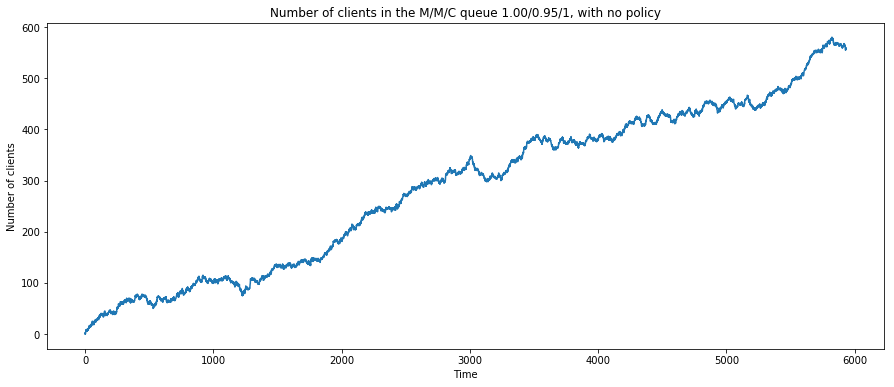

In [20]:
T1, N1, _ = MM1Normal(arrivals, c, Tmax)
start_index1 = int(len(T1)*start_prop)
end_index1 = int(len(T1)*end_prop)
figure(figsize=(15,6))
plot(T1[start_index1:end_index1], N1[start_index1:end_index1])
#scatter(T1[start_index:end_index], N1[start_index:end_index])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with no policy' % (lambd, mu1, c))

Look ahead from 1 at time 0.100 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 1.818 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 1.843 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 2.741 has Departures 9349 Arrivals 10059 -> use FAST 1
Look ahead from 1 at time 2.816 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 4.693 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 5.211 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 6.198 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 6.642 has Departures 9347 Arrivals 10054 -> use FAST 1
Look ahead from 1 at time 6.746 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 7.174 has Departures 5 Arrivals 5 -> use SLOW 1
Look ahead from 3 at time 8.904 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 9.471 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 3 at tim

Look ahead from 1 at time 143.461 has Departures 9231 Arrivals 9906 -> use FAST 1
Look ahead from 1 at time 144.136 has Departures 9238 Arrivals 9905 -> use FAST 1
Look ahead from 1 at time 144.262 has Departures 29 Arrivals 29 -> use SLOW 1
Look ahead from 4 at time 147.199 has Departures 12 Arrivals 12 -> use SLOW 2
Look ahead from 7 at time 148.143 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 6 at time 148.339 has Departures 6 Arrivals 6 -> use SLOW 2
Look ahead from 7 at time 148.872 has Departures 4 Arrivals 4 -> use SLOW 2
Look ahead from 8 at time 149.804 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 9 at time 154.071 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 8 at time 154.533 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 7 at time 154.813 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 6 at time 155.971 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 6 at time 157.574 has Departures 1 Arrivals 1 -> use SLO

Look ahead from 1 at time 250.084 has Departures 9144 Arrivals 9797 -> use FAST 1
Look ahead from 1 at time 250.383 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 250.801 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 251.342 has Departures 9144 Arrivals 9794 -> use FAST 1
Look ahead from 1 at time 251.439 has Departures 9143 Arrivals 9793 -> use FAST 1
Look ahead from 1 at time 251.731 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 255.773 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 255.841 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 2 at time 256.479 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 256.819 has Departures 8 Arrivals 8 -> use SLOW 2
Look ahead from 4 at time 259.165 has Departures 3 Arrivals 3 -> use SLOW 2
Look ahead from 5 at time 259.713 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 5 at time 262.781 has Departures 1 Arrivals 0 -> use S

Look ahead from 1 at time 611.713 has Departures 8786 Arrivals 9428 -> use FAST 1
Look ahead from 1 at time 612.162 has Departures 4 Arrivals 4 -> use SLOW 1
Look ahead from 2 at time 614.123 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 3 at time 615.066 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 616.150 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 616.187 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 2 at time 616.957 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 618.788 has Departures 8780 Arrivals 9421 -> use FAST 2
Look ahead from 1 at time 618.810 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 619.665 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 620.522 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 621.888 has Departures 14 Arrivals 14 -> use SLOW 1
Look ahead from 3 at time 623.519 has Departures 1 Arrivals 1 -> use SLOW 

Look ahead from 1 at time 751.183 has Departures 8662 Arrivals 9281 -> use FAST 2
Look ahead from 1 at time 751.482 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 752.510 has Departures 8662 Arrivals 9279 -> use FAST 1
Look ahead from 1 at time 752.701 has Departures 8662 Arrivals 9278 -> use FAST 1
Look ahead from 1 at time 753.030 has Departures 8661 Arrivals 9277 -> use FAST 1
Look ahead from 1 at time 753.977 has Departures 152 Arrivals 152 -> use SLOW 1
Look ahead from 4 at time 755.160 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 3 at time 755.778 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 3 at time 756.955 has Departures 7 Arrivals 7 -> use SLOW 2
Look ahead from 4 at time 757.390 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 4 at time 758.182 has Departures 4 Arrivals 4 -> use SLOW 2
Look ahead from 5 at time 761.526 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 6 at time 763.001 has Departures 1 Arrivals 

Look ahead from 9 at time 1253.473 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 10 at time 1254.787 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 9 at time 1255.157 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 8 at time 1256.563 has Departures 6 Arrivals 6 -> use SLOW 2
Look ahead from 10 at time 1258.127 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 10 at time 1258.277 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 9 at time 1259.614 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 9 at time 1260.139 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 9 at time 1261.466 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 8 at time 1261.636 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 8 at time 1264.700 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 7 at time 1264.763 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 6 at time 1267.209 has Departures 1 Arrivals 1 -> use SLO

Look ahead from 1 at time 1665.602 has Departures 7792 Arrivals 8365 -> use FAST 2
Look ahead from 1 at time 1665.799 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 1666.537 has Departures 7793 Arrivals 8363 -> use FAST 2
Look ahead from 1 at time 1667.331 has Departures 3 Arrivals 3 -> use SLOW 1
Look ahead from 2 at time 1667.759 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 2 at time 1670.544 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 1670.657 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 1671.221 has Departures 4 Arrivals 4 -> use SLOW 1
Look ahead from 4 at time 1673.917 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 3 at time 1674.429 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 1674.524 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 1675.367 has Departures 7787 Arrivals 8354 -> use FAST 2
Look ahead from 1 at time 1675.402 has Departures 7786 Arr

Look ahead from 1 at time 1863.959 has Departures 7618 Arrivals 8160 -> use FAST 2
Look ahead from 1 at time 1864.050 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 1864.380 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 1865.707 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 1866.336 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 1 at time 1867.553 has Departures 23 Arrivals 23 -> use SLOW 2
Look ahead from 3 at time 1870.258 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 1872.445 has Departures 8 Arrivals 8 -> use SLOW 2
Look ahead from 7 at time 1875.777 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 7 at time 1876.962 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 6 at time 1877.670 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 6 at time 1878.338 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 5 at time 1878.928 has Departures 1 Arrivals 0 -> us

Look ahead from 1 at time 1980.843 has Departures 7528 Arrivals 8042 -> use FAST 1
Look ahead from 1 at time 1981.141 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 1981.634 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 1982.752 has Departures 7525 Arrivals 8039 -> use FAST 2
Look ahead from 1 at time 1983.092 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 1984.585 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 1984.672 has Departures 7523 Arrivals 8036 -> use FAST 2
Look ahead from 1 at time 1985.027 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 1985.402 has Departures 7521 Arrivals 8034 -> use FAST 1
Look ahead from 1 at time 1985.761 has Departures 7521 Arrivals 8033 -> use FAST 1
Look ahead from 1 at time 1986.676 has Departures 7527 Arrivals 8032 -> use FAST 1
Look ahead from 1 at time 1986.709 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 1987.777 has D

Look ahead from 14 at time 2084.440 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 13 at time 2084.583 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 13 at time 2086.275 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 13 at time 2086.586 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 12 at time 2086.668 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 11 at time 2087.138 has Departures 3 Arrivals 3 -> use SLOW 2
Look ahead from 13 at time 2091.482 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 12 at time 2091.547 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 11 at time 2091.648 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 10 at time 2092.807 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 9 at time 2092.859 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 10 at time 2093.414 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 9 at time 2093.576 has Departures 7 Arrivals 7 ->

Look ahead from 1 at time 2232.948 has Departures 7284 Arrivals 7765 -> use FAST 1
Look ahead from 1 at time 2233.201 has Departures 4 Arrivals 4 -> use SLOW 1
Look ahead from 3 at time 2234.210 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 3 at time 2236.430 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 2237.226 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 2237.299 has Departures 7281 Arrivals 7760 -> use FAST 2
Look ahead from 1 at time 2237.365 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 2238.083 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 1 at time 2238.541 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 2240.504 has Departures 12 Arrivals 12 -> use SLOW 1
Look ahead from 3 at time 2241.690 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 2241.899 has Departures 3 Arrivals 3 -> use SLOW 2
Look ahead from 4 at time 2243.001 has Departures 1 Arrivals 0

Look ahead from 1 at time 2396.840 has Departures 7149 Arrivals 7595 -> use FAST 1
Look ahead from 1 at time 2396.873 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 2396.977 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 2397.282 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 2399.313 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 2400.556 has Departures 3 Arrivals 3 -> use SLOW 1
Look ahead from 3 at time 2402.114 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 2402.178 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 2402.895 has Departures 13 Arrivals 13 -> use SLOW 2
Look ahead from 2 at time 2403.896 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 2 at time 2406.159 has Departures 10 Arrivals 10 -> use SLOW 2
Look ahead from 4 at time 2408.979 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 4 at time 2410.029 has Departures 2 Arrivals 2 -> 

Look ahead from 14 at time 2553.955 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 13 at time 2553.955 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 13 at time 2554.972 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 13 at time 2556.790 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 13 at time 2557.747 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 12 at time 2558.761 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 11 at time 2559.037 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 10 at time 2559.966 has Departures 39 Arrivals 39 -> use SLOW 2
Look ahead from 12 at time 2561.802 has Departures 35 Arrivals 35 -> use SLOW 2
Look ahead from 16 at time 2564.115 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 17 at time 2566.153 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 16 at time 2566.354 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 15 at time 2566.714 has Departures 1 Arrival

Look ahead from 1 at time 2971.693 has Departures 6586 Arrivals 6986 -> use FAST 1
Look ahead from 1 at time 2971.753 has Departures 6586 Arrivals 6985 -> use FAST 1
Look ahead from 1 at time 2971.933 has Departures 6585 Arrivals 6984 -> use FAST 1
Look ahead from 1 at time 2972.012 has Departures 6584 Arrivals 6983 -> use FAST 1
Look ahead from 1 at time 2972.206 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 2973.581 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 2975.066 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 2975.131 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 1 at time 2975.419 has Departures 6581 Arrivals 6978 -> use FAST 2
Look ahead from 1 at time 2977.325 has Departures 6580 Arrivals 6977 -> use FAST 1
Look ahead from 1 at time 2977.467 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 2978.060 has Departures 6 Arrivals 6 -> use SLOW 2
Look ahead from 6 at time 2980.184 has D

Look ahead from 1 at time 3350.011 has Departures 6216 Arrivals 6603 -> use FAST 2
Look ahead from 1 at time 3350.447 has Departures 6218 Arrivals 6602 -> use FAST 1
Look ahead from 1 at time 3350.539 has Departures 6217 Arrivals 6601 -> use FAST 1
Look ahead from 1 at time 3350.719 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 3352.095 has Departures 41 Arrivals 41 -> use SLOW 1
Look ahead from 4 at time 3357.032 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 4 at time 3358.152 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 4 at time 3358.889 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 3 at time 3360.286 has Departures 31 Arrivals 31 -> use SLOW 2
Look ahead from 5 at time 3361.048 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 6 at time 3362.763 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 5 at time 3363.436 has Departures 9 Arrivals 9 -> use SLOW 2
Look ahead from 10 at time 3367.063 has Departures 1 A

Look ahead from 6 at time 4013.498 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 6 at time 4014.572 has Departures 23 Arrivals 23 -> use SLOW 2
Look ahead from 8 at time 4016.250 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 7 at time 4016.410 has Departures 6 Arrivals 6 -> use SLOW 2
Look ahead from 8 at time 4017.457 has Departures 4 Arrivals 4 -> use SLOW 2
Look ahead from 9 at time 4017.922 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 10 at time 4018.510 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 9 at time 4018.682 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 8 at time 4018.749 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 7 at time 4018.915 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 7 at time 4019.549 has Departures 13 Arrivals 13 -> use SLOW 2
Look ahead from 11 at time 4024.416 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 11 at time 4024.701 has Departures 1 Arrivals 0 -> use

Look ahead from 1 at time 4370.207 has Departures 5236 Arrivals 5545 -> use FAST 1
Look ahead from 1 at time 4370.231 has Departures 5240 Arrivals 5544 -> use FAST 1
Look ahead from 1 at time 4370.253 has Departures 5240 Arrivals 5543 -> use FAST 1
Look ahead from 1 at time 4370.699 has Departures 5239 Arrivals 5542 -> use FAST 1
Look ahead from 1 at time 4371.034 has Departures 7 Arrivals 7 -> use SLOW 1
Look ahead from 3 at time 4373.184 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 4 at time 4374.617 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 3 at time 4374.817 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 4374.884 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 3 at time 4375.839 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 4376.116 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 4376.619 has Departures 5232 Arrivals 5534 -> use FAST 2
Look ahead from 1 at time 4376.983 has Departu

Look ahead from 1 at time 4551.806 has Departures 5082 Arrivals 5361 -> use FAST 2
Look ahead from 1 at time 4552.037 has Departures 5083 Arrivals 5360 -> use FAST 1
Look ahead from 1 at time 4552.138 has Departures 5083 Arrivals 5359 -> use FAST 1
Look ahead from 1 at time 4552.834 has Departures 5084 Arrivals 5358 -> use FAST 1
Look ahead from 1 at time 4552.949 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 4554.496 has Departures 8 Arrivals 8 -> use SLOW 1
Look ahead from 4 at time 4556.462 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 3 at time 4557.292 has Departures 4 Arrivals 4 -> use SLOW 2
Look ahead from 5 at time 4560.409 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 4 at time 4563.304 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 4 at time 4563.834 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 3 at time 4564.174 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 2 at time 4564.389 has Departures 1 

Look ahead from 1 at time 4752.176 has Departures 4905 Arrivals 5155 -> use FAST 2
Look ahead from 1 at time 4752.738 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 4753.032 has Departures 4904 Arrivals 5153 -> use FAST 1
Look ahead from 1 at time 4753.090 has Departures 4903 Arrivals 5152 -> use FAST 1
Look ahead from 1 at time 4753.247 has Departures 4903 Arrivals 5151 -> use FAST 1
Look ahead from 1 at time 4753.286 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 4753.410 has Departures 4901 Arrivals 5149 -> use FAST 2
Look ahead from 1 at time 4753.733 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 4756.016 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 4756.054 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 4756.727 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 4761.368 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 4761.888 has Departu

Look ahead from 1 at time 5279.919 has Departures 4444 Arrivals 4669 -> use FAST 2
Look ahead from 1 at time 5280.394 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 5281.316 has Departures 4443 Arrivals 4667 -> use FAST 2
Look ahead from 1 at time 5282.120 has Departures 4443 Arrivals 4666 -> use FAST 1
Look ahead from 1 at time 5282.471 has Departures 3 Arrivals 3 -> use SLOW 1
Look ahead from 2 at time 5284.028 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 2 at time 5285.368 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 5285.661 has Departures 4442 Arrivals 4662 -> use FAST 2
Look ahead from 1 at time 5285.699 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 5286.391 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 5287.079 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 5289.481 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 5290.688 has Departures 1 

Look ahead from 1 at time 5497.662 has Departures 4231 Arrivals 4430 -> use FAST 1
Look ahead from 1 at time 5498.180 has Departures 4230 Arrivals 4429 -> use FAST 1
Look ahead from 1 at time 5498.262 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 5499.535 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 5499.705 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 5499.933 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 5500.629 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 5501.471 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 5502.911 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 5503.880 has Departures 4223 Arrivals 4421 -> use FAST 1
Look ahead from 1 at time 5504.274 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 5505.332 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 5505.956 has Departures 37 Arriv

Look ahead from 1 at time 5650.140 has Departures 4091 Arrivals 4252 -> use FAST 1
Look ahead from 1 at time 5650.616 has Departures 4093 Arrivals 4251 -> use FAST 1
Look ahead from 1 at time 5650.860 has Departures 4093 Arrivals 4250 -> use FAST 1
Look ahead from 1 at time 5651.722 has Departures 4092 Arrivals 4249 -> use FAST 1
Look ahead from 1 at time 5651.903 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 5652.137 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 5653.263 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 1 at time 5654.160 has Departures 4090 Arrivals 4245 -> use FAST 2
Look ahead from 1 at time 5654.817 has Departures 4090 Arrivals 4244 -> use FAST 1
Look ahead from 1 at time 5655.113 has Departures 5 Arrivals 5 -> use SLOW 1
Look ahead from 2 at time 5655.325 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 2 at time 5656.588 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 2 at time 5658.516 has D

Look ahead from 13 at time 5939.115 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 13 at time 5941.187 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 12 at time 5942.146 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 12 at time 5942.819 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 11 at time 5942.866 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 10 at time 5943.158 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 9 at time 5943.720 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 8 at time 5943.758 has Departures 3 Arrivals 3 -> use SLOW 2
Look ahead from 10 at time 5944.873 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 9 at time 5945.248 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 8 at time 5945.557 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 7 at time 5947.494 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 6 at time 5947.980 has Departures 2 Arrivals 2 -> use

Look ahead from 21 at time 6489.676 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 20 at time 6489.703 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 19 at time 6490.139 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 18 at time 6490.145 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 17 at time 6490.994 has Departures 24 Arrivals 24 -> use SLOW 2
Look ahead from 20 at time 6492.359 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 19 at time 6492.429 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 19 at time 6493.777 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 20 at time 6494.783 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 19 at time 6495.262 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 18 at time 6495.267 has Departures 17 Arrivals 17 -> use SLOW 2
Look ahead from 22 at time 6496.718 has Departures 7 Arrivals 7 -> use SLOW 2
Look ahead from 23 at time 6499.630 has Departures 5 Arrival

Look ahead from 1 at time 6891.018 has Departures 2912 Arrivals 2998 -> use FAST 1
Look ahead from 1 at time 6891.218 has Departures 3 Arrivals 3 -> use SLOW 1
Look ahead from 2 at time 6893.485 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 2 at time 6893.757 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 6894.075 has Departures 2908 Arrivals 2994 -> use FAST 2
Look ahead from 1 at time 6894.401 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 6894.619 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 6895.234 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 6896.002 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 6896.236 has Departures 2904 Arrivals 2989 -> use FAST 1
Look ahead from 1 at time 6896.421 has Departures 2903 Arrivals 2988 -> use FAST 1
Look ahead from 1 at time 6896.465 has Departures 6 Arrivals 6 -> use SLOW 1
Look ahead from 5 at time 6900.108 has Departures 1 

Look ahead from 10 at time 7249.167 has Departures 9 Arrivals 9 -> use SLOW 2
Look ahead from 12 at time 7252.355 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 11 at time 7253.414 has Departures 6 Arrivals 6 -> use SLOW 2
Look ahead from 13 at time 7254.992 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 13 at time 7255.462 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 12 at time 7255.482 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 13 at time 7257.074 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 12 at time 7257.896 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 11 at time 7257.906 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 10 at time 7258.358 has Departures 3 Arrivals 3 -> use SLOW 2
Look ahead from 11 at time 7259.522 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 11 at time 7260.462 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 10 at time 7260.517 has Departures 1 Arrivals 0 

Look ahead from 63 at time 8017.881 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 62 at time 8018.364 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 61 at time 8019.542 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 60 at time 8020.339 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 59 at time 8020.930 has Departures 67 Arrivals 67 -> use SLOW 2
Look ahead from 61 at time 8024.429 has Departures 34 Arrivals 34 -> use SLOW 2
Look ahead from 65 at time 8026.993 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 64 at time 8027.111 has Departures 4 Arrivals 4 -> use SLOW 2
Look ahead from 65 at time 8030.785 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 66 at time 8031.487 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 65 at time 8032.767 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 64 at time 8032.779 has Departures 1 Arrivals 1 -> use SLOW 2
Look ahead from 64 at time 8034.493 has Departures 1 Arrival

Look ahead from 2 at time 9009.799 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 9010.844 has Departures 2 Arrivals 2 -> use SLOW 2
Look ahead from 2 at time 9014.497 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 9015.606 has Departures 897 Arrivals 930 -> use FAST 2
Look ahead from 1 at time 9016.713 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 9016.944 has Departures 1 Arrivals 0 -> use SLOW 2
Look ahead from 1 at time 9019.210 has Departures 1 Arrivals 0 -> use SLOW 1
Look ahead from 1 at time 9020.881 has Departures 893 Arrivals 926 -> use FAST 1
Look ahead from 1 at time 9021.336 has Departures 894 Arrivals 925 -> use FAST 1
Look ahead from 1 at time 9021.690 has Departures 1 Arrivals 1 -> use SLOW 1
Look ahead from 1 at time 9024.291 has Departures 897 Arrivals 923 -> use FAST 2
Look ahead from 1 at time 9024.766 has Departures 2 Arrivals 2 -> use SLOW 1
Look ahead from 2 at time 9025.547 has Departures 1 Arrivals

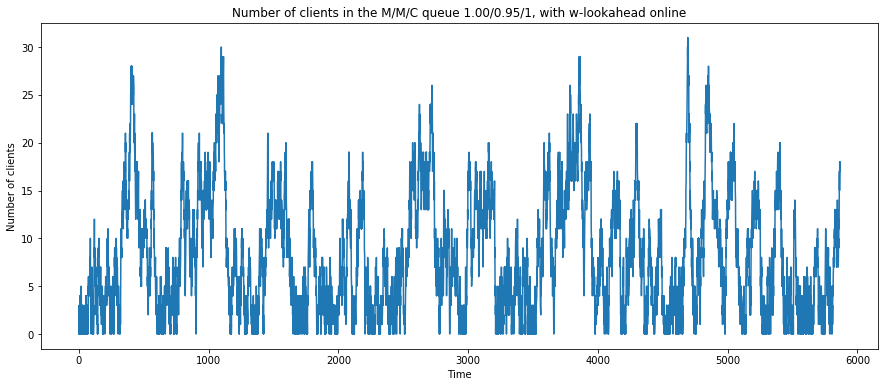

In [26]:
T3, N3, _, use_surge = MM1WithWLookaheadConstant(arrivals, c, w, Tmax)

start_index3 = int(len(T3)*start_prop)
end_index3 = int(len(T3)*end_prop)
figure(figsize=(15,6))
#scatter(T3[start_index:end_index], N3[start_index:end_index])
plot(T3[start_index3:end_index3], N3[start_index3:end_index3])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with w-lookahead online'
      % (lambd, mu1, c))
print("Use surge %.2f" % (use_surge))

In [22]:
len(N1)

19419

Use surge 0.07


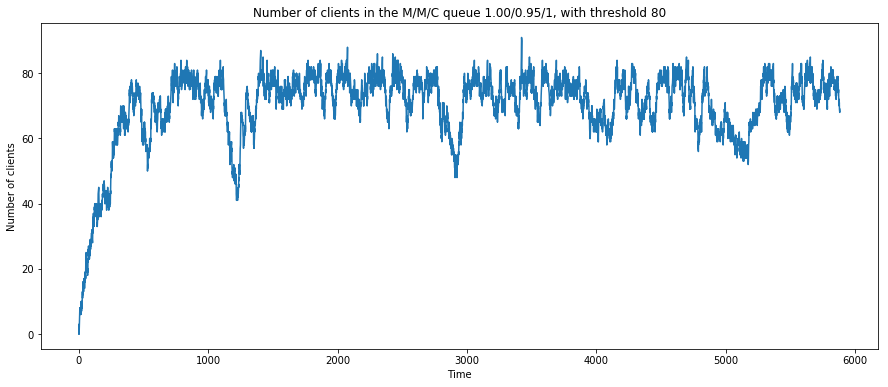

In [23]:
T2, N2, _, use_surge = MM1WithOneThreshold(arrivals, surge_threshold, c, Tmax)

start_index2 = int(len(T2)*start_prop)
end_index2 = int(len(T2)*end_prop)
figure(figsize=(15,6))
plot(T2[start_index2:end_index2], N2[start_index2:end_index2])
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with threshold %d'
      % (lambd, mu1, c, surge_threshold))
print("Use surge %.2f" % (use_surge))

Text(0.5,1,'Number of clients in the M/M/C queue 1.00/0.95/1, with different heuristics')

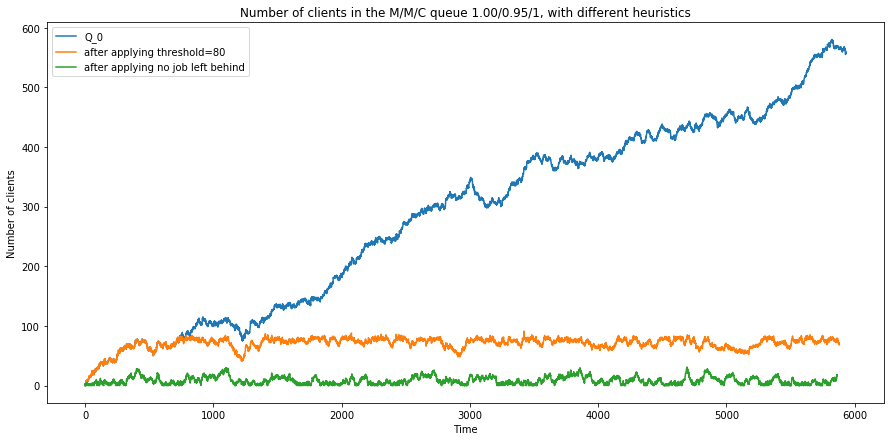

In [24]:
figure(figsize=(15,7))
plot(T1[start_index1:end_index1], N1[start_index1:end_index1], label="Q_0")
plot(T2[start_index2:end_index2], N2[start_index2:end_index2], label="after applying threshold=80")
plot(T3[start_index3:end_index3], N3[start_index3:end_index3], label="after applying no job left behind")
xlabel('Time')
ylabel('Number of clients')
legend()
title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with different heuristics'
      % (lambd, mu1, c))

In [16]:
'''##### SURGE count and proportion #####
            if T[-1] >= 1000 and T[-1] <= 9000:
                if in_surge == 0 and S == 0: # first time, mark t_temp
                    start_measuring_surge = T[-2]
                t_delta = T[-1] - popped_customer.enter_service_time
                S = S + (t_delta * N[-2])
                if popped_customer.fast:
                    in_surge = in_surge + t_delta
            if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]'''

'##### SURGE count and proportion #####\n            if T[-1] >= 1000 and T[-1] <= 9000:\n                if in_surge == 0 and S == 0: # first time, mark t_temp\n                    start_measuring_surge = T[-2]\n                t_delta = T[-1] - popped_customer.enter_service_time\n                S = S + (t_delta * N[-2])\n                if popped_customer.fast:\n                    in_surge = in_surge + t_delta\n            if T[-1] > 9000:\n                if end_measuring_surge == 0:\n                    end_measuring_surge = T[-1]'